In [28]:
import pandas as pd

# Load both datasets
with_tutorial = pd.read_csv("detailed_events_with_tutorial.csv")
no_tutorial = pd.read_csv("detailed_events_no_tutorial.csv")

# Clean up labels and names
def clean_data(df):
    df["eventLabel"] = df["eventLabel"].fillna("Unlabeled").str.strip()
    df["eventName"] = df["eventName"].str.strip()
    # Truncate eventLabels at the dash
    df["eventLabel"] = df["eventLabel"].apply(lambda x: x.split("-")[0].strip() if "-" in x else x)
    return df

with_tutorial = clean_data(with_tutorial)
no_tutorial = clean_data(no_tutorial)


In [29]:
# Grouping function
def aggregate_event_data(df):
    return df.groupby(["eventName", "eventLabel"]).agg({
        "eventCount": "sum",
        "userEngagementDuration": "sum"
    }).reset_index().sort_values("eventCount", ascending=False)

agg_with = aggregate_event_data(with_tutorial)
agg_no = aggregate_event_data(no_tutorial)

# Preview top events from each group
print("With Tutorial:")
print(agg_with.head(), "\n")

print("No Tutorial:")
print(agg_no.head())


With Tutorial:
        eventName  eventLabel  eventCount  userEngagementDuration
19      page_view   Unlabeled          97                       0
16     Tab Viewed  User Guide          88                       5
21  session_start   Unlabeled          68                       0
20         scroll   Unlabeled          57                     237
10   Tab Duration  User Guide          55                     226 

No Tutorial:
        eventName  eventLabel  eventCount  userEngagementDuration
18      page_view   Unlabeled         101                       0
20  session_start   Unlabeled          73                       0
16    first_visit   Unlabeled          60                       0
19         scroll   Unlabeled          54                     170
14     Tab Viewed  User Guide          52                       1


In [30]:
# Define labels for metrics of interest
task_labels = ["Apply Numeric", "Clean Data"]
tutorial_labels = ["Start Tutorial", "Skip Tutorial"]
tab_labels = ["Raw Data Preview", "User Guide", "Cleaned Data Preview"]
bounce_event = ("Page Leave", "Unlabeled")

# Helper to sum event counts for a list of labels under "Click"
def sum_click_events(df, labels):
    return df[
        (df["eventName"] == "Click") & (df["eventLabel"].isin(labels))
    ]["eventCount"].sum()

# Helper for tab duration: sum userEngagementDuration
def sum_tab_duration(df, labels):
    return df[
        (df["eventName"] == "Tab Duration") & (df["eventLabel"].isin(labels))
    ]["userEngagementDuration"].sum()

# Helper for bounce
def get_page_leaves(df):
    return df[
        (df["eventName"] == bounce_event[0]) & (df["eventLabel"] == bounce_event[1])
    ]["eventCount"].sum()

# Compile metrics
def compile_metrics(df):
    return {
        "Task Completions": sum_click_events(df, task_labels),
        "Page Leaves": get_page_leaves(df),
        "Tab Duration (total sec)": sum_tab_duration(df, tab_labels),
        "Tutorial Starts": sum_click_events(df, ["Start Tutorial"]),
        "Tutorial Skips": sum_click_events(df, ["Skip Tutorial"]),
    }

metrics_with = compile_metrics(agg_with)
metrics_no = compile_metrics(agg_no)

# View side-by-side
ab_summary = pd.DataFrame([metrics_no, metrics_with], index=["No Tutorial", "With Tutorial"])
print(ab_summary)


               Task Completions  Page Leaves  Tab Duration (total sec)  \
No Tutorial                  42           29                       646   
With Tutorial                53           34                       361   

               Tutorial Starts  Tutorial Skips  
No Tutorial                  0               0  
With Tutorial               34               7  


EXPLORATORY DATA ANALYSIS

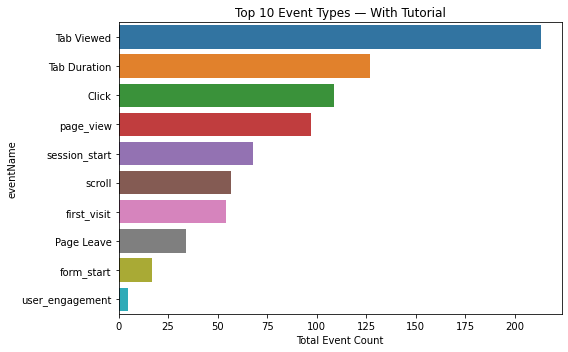

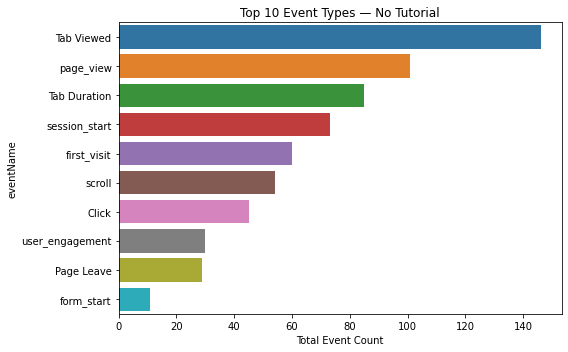

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Show top 10 most common event types (regardless of label)
def plot_event_distribution(df, label):
    event_totals = df.groupby("eventName")["eventCount"].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=event_totals.values, y=event_totals.index)
    plt.title(f"Top 10 Event Types — {label}")
    plt.xlabel("Total Event Count")
    plt.tight_layout()
    plt.show()

plot_event_distribution(with_tutorial, "With Tutorial")
plot_event_distribution(no_tutorial, "No Tutorial")


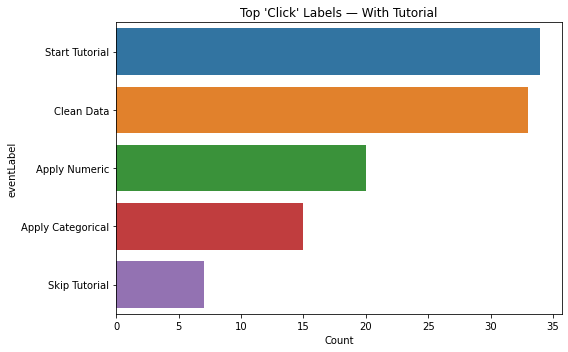

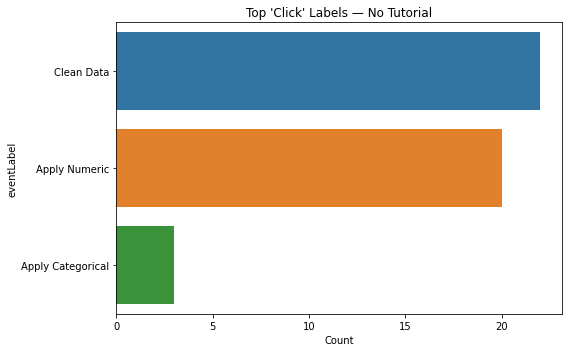

In [22]:
# Show top labels within the 'Click' event
def plot_top_event_labels(df, event_type, label):
    click_labels = df[df["eventName"] == event_type].groupby("eventLabel")["eventCount"].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=click_labels.values, y=click_labels.index)
    plt.title(f"Top '{event_type}' Labels — {label}")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

plot_top_event_labels(with_tutorial, "Click", "With Tutorial")
plot_top_event_labels(no_tutorial, "Click", "No Tutorial")


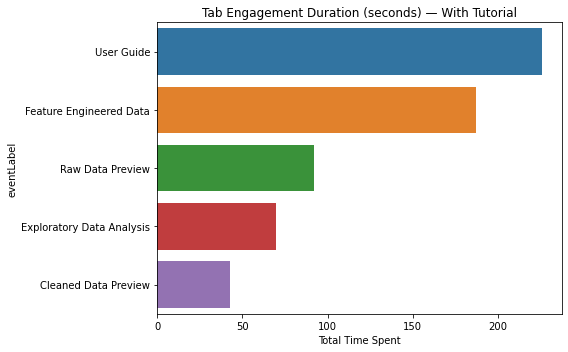

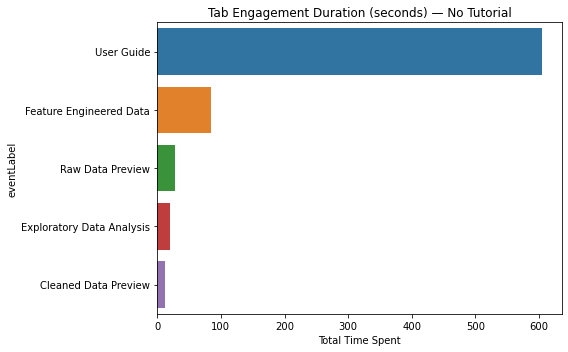

In [33]:
# Plot total engagement time per tab
def plot_tab_engagement(df, label):
    tabs = df[df["eventName"] == "Tab Duration"].groupby("eventLabel")["userEngagementDuration"].sum().sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=tabs.values, y=tabs.index)
    plt.title(f"Tab Engagement Duration (seconds) — {label}")
    plt.xlabel("Total Time Spent")
    plt.tight_layout()
    plt.show()

plot_tab_engagement(with_tutorial, "With Tutorial")
plot_tab_engagement(no_tutorial, "No Tutorial")


In [34]:
from scipy.stats import chi2_contingency

# Helper to run and print chi-squared test results
def run_chi2_test(metric_name, count_no, count_with, total_no, total_with):
    contingency = [
        [count_no, total_no - count_no],
        [count_with, total_with - count_with]
    ]
    chi2, p, dof, _ = chi2_contingency(contingency)
    print(f"{metric_name}:\n"
          f"  No Tutorial = {count_no} / {total_no}, "
          f"With Tutorial = {count_with} / {total_with}\n"
          f"  p-value = {p:.4f}")
    print("-" * 40)

# Total clicks for context (or use total events if available)
total_events_no = agg_no["eventCount"].sum()
total_events_with = agg_with["eventCount"].sum()

# Run tests
run_chi2_test("Task Completions",
              metrics_no["Task Completions"], metrics_with["Task Completions"],
              total_events_no, total_events_with)

run_chi2_test("Page Leaves",
              metrics_no["Page Leaves"], metrics_with["Page Leaves"],
              total_events_no, total_events_with)


Task Completions:
  No Tutorial = 42 / 635, With Tutorial = 53 / 781
  p-value = 0.9826
----------------------------------------
Page Leaves:
  No Tutorial = 29 / 635, With Tutorial = 34 / 781
  p-value = 0.9488
----------------------------------------


There is no statistically significant difference in task completion rates between the two versions of the app.
The tutorial did not appear to impact whether users completed tasks (like Apply Numeric or Clean Data).
The tutorial did not reduce or increase the bounce/exit behavior of users.

In [35]:
from scipy.stats import ttest_ind

# Extract per-row tab duration values for both groups
def extract_tab_durations(df):
    return df[df["eventName"] == "Tab Duration"][["eventLabel", "userEngagementDuration"]]

tabs_with = extract_tab_durations(with_tutorial)
tabs_no = extract_tab_durations(no_tutorial)

# Perform Welch's t-test
t_stat, p_value = ttest_ind(tabs_with["userEngagementDuration"], tabs_no["userEngagementDuration"], equal_var=False)

# Print results
print(f"Mean Duration (With Tutorial): {tabs_with['userEngagementDuration'].mean():.2f} sec")
print(f"Mean Duration (No Tutorial):   {tabs_no['userEngagementDuration'].mean():.2f} sec")
print(f"Welch’s t-test p-value: {p_value:.4f}")


Mean Duration (With Tutorial): 41.20 sec
Mean Duration (No Tutorial):   62.58 sec
Welch’s t-test p-value: 0.6290


There is no statistically significant difference in tab engagement duration between users who saw the tutorial and those who didn't (p = 0.6290).

In fact, the group without the tutorial spent slightly more time on tabs on average — though this result is not statistically meaningful.

In [38]:
# Filter Click events related to tutorial
tutorial_clicks = with_tutorial[
    (with_tutorial["eventName"] == "Click") &
    (with_tutorial["eventLabel"].isin(["Start Tutorial", "Skip Tutorial"]))
]

# Summarize counts
tutorial_summary = tutorial_clicks.groupby("eventLabel")["eventCount"].sum().reset_index()
tutorial_summary.columns = ["Tutorial Action", "Count"]
tutorial_summary


,Tutorial Action,Count
0,Skip Tutorial,7
1,Start Tutorial,34


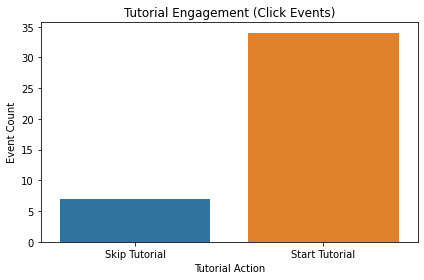

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(data=tutorial_summary, x="Tutorial Action", y="Count")
plt.title("Tutorial Engagement (Click Events)")
plt.ylabel("Event Count")
plt.tight_layout()
plt.show()


In [41]:
# Total unique site entries
total_visits = with_tutorial[
    with_tutorial["eventName"] == "first_visit"
]["eventCount"].sum()

# Total starts of the tutorial
tutorial_starts = with_tutorial[
    (with_tutorial["eventName"] == "Click") &
    (with_tutorial["eventLabel"] == "Start Tutorial")
]["eventCount"].sum()

# Uptake rate
uptake_rate = tutorial_starts / total_visits if total_visits > 0 else 0

print(f"Total Visitors: {total_visits}")
print(f"Tutorial Starts: {tutorial_starts}")
print(f"Tutorial Uptake Rate: {uptake_rate:.2%}")


Total Visitors: 54
Tutorial Starts: 34
Tutorial Uptake Rate: 62.96%


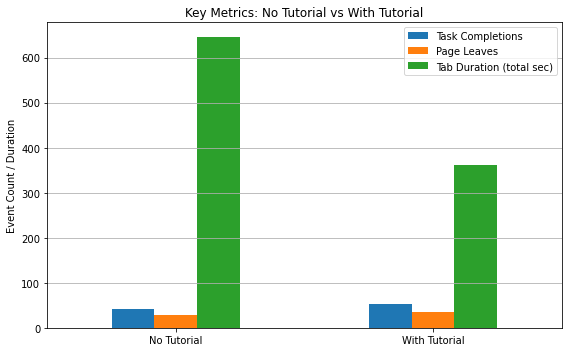

In [42]:
# Data from earlier summary
ab_summary = pd.DataFrame([metrics_no, metrics_with], index=["No Tutorial", "With Tutorial"])

# Drop tutorial-only metrics
ab_plot = ab_summary.drop(columns=["Tutorial Starts", "Tutorial Skips"])

ab_plot.plot(kind="bar", figsize=(8, 5))
plt.title("Key Metrics: No Tutorial vs With Tutorial")
plt.ylabel("Event Count / Duration")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()
